In [1]:
import numpy as np
from sklearn.neighbors import KernelDensity

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

# Plots
plt.style.use('seaborn-whitegrid')

# PLOT PREAMBLE: LIKE LATEX
LATEX_WIDTH = 6
LATEX_HEIGHT = 3.24

SCRIPT_SIZE = 7

#Direct input
plt.rcParams['text.latex.preamble']=r"\usepackage{lmodern}"
#Options
params = {'text.usetex' : True,
          'font.size' : SCRIPT_SIZE,
          'axes.labelsize' : SCRIPT_SIZE,
          'xtick.labelsize' : SCRIPT_SIZE,
          'ytick.labelsize' : SCRIPT_SIZE,
          'legend.fontsize' : SCRIPT_SIZE,
          'figure.titlesize' : SCRIPT_SIZE,
          'font.family' : 'serif',
          'font.serif': ['Computer Modern Roman']
          }
plt.rcParams.update(params)

In [2]:
# Load data
thetas_prior = np.load('../../results/log_normal/prior_log_normal.npy').squeeze()
thetas_approx = np.load('../../results/log_normal/laplace.npy').squeeze()

mu_true, sigma_sq_true = thetas_prior[:, 0], thetas_prior[:, 1]
mu_approx, sigma_sq_approx = thetas_approx[:, 0], thetas_approx[:, 1]

In [3]:
def fit_kde(ts, vals, kernel, bw, mirror=False):
    """Fit kernel density to data. If mirror=True, symmetrically extend the dataset around 0 to get the hard border at 0 right."""
    kde = KernelDensity(bandwidth=bw, kernel=kernel)
    if mirror==True:
        vals_extended = np.concatenate((-vals, vals))
        kde.fit(vals_extended[:, None])
        probs = 2 * np.exp(kde.score_samples(ts[:, None]))
    else:
        kde.fit(vals[:, None])
        probs = np.exp(kde.score_samples(ts[:, None]))
    return probs

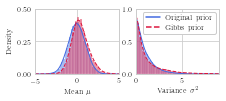

In [4]:
alpha_bins = .5
fig, axs = plt.subplots(ncols=2, figsize=(.55*LATEX_WIDTH, .2*LATEX_WIDTH))

bins_mu = np.linspace(-5, 5, 55)
sns.histplot(mu_true, ax=axs[0], label='Prior', color='royalblue', kde=False, stat='density', edgecolor="white", bins=bins_mu, alpha=alpha_bins)
sns.histplot(mu_approx, ax=axs[0], label='Gibbs prior', color='crimson', kde=False, stat='density', edgecolor="white", bins=bins_mu, alpha=alpha_bins)
axs[0].set_xlabel(r'Mean $\mu$')
axs[0].set_xlim((-5, 5))

bins_sigma_sq = np.linspace(0, 10, 55)
sns.histplot(sigma_sq_true, stat='density', ax=axs[1], label=r'Original prior', color='royalblue', kde=False, edgecolor="white", bins=bins_sigma_sq, alpha=alpha_bins)
sns.histplot(np.clip(sigma_sq_approx, a_min=0, a_max=10), stat='density', ax=axs[1], color='crimson',
             label=r'Gibbs prior', kde=False, edgecolor="white", bins=bins_sigma_sq, alpha=alpha_bins)


# Manually fit kernel density for sigma_sq, because Gaussian kernel is inappropriate for the hard boundary at 0
# mu
ts_mu = np.linspace(-5, 5, 500)
bw_mu = .25

prob_mu_true = fit_kde(ts_mu, mu_true, 'gaussian', bw_mu)
prob_mu_approx = fit_kde(ts_mu, mu_approx, 'gaussian', bw_mu)

axs[0].plot(ts_mu, prob_mu_true, color='royalblue', linewidth=1, linestyle='-')
axs[0].plot(ts_mu, prob_mu_approx, color='crimson', linewidth=1, linestyle='--')

ts_sigma_sq = np.linspace(0, 10, 500)
bw_sigma_sq = .2

prob_sigma_true = fit_kde(ts_sigma_sq, sigma_sq_true, 'gaussian', bw_sigma_sq, mirror=True)
prob_sigma_approx = fit_kde(ts_sigma_sq, sigma_sq_approx, 'gaussian', bw_sigma_sq, mirror=True)

axs[1].plot(ts_sigma_sq, prob_sigma_true, color='royalblue', linewidth=1, linestyle='-')
axs[1].plot(ts_sigma_sq, prob_sigma_approx, color='crimson', linewidth=1, linestyle='--')

axs[1].set_xlim([0, 9])

axs[1].set_xlabel(r'Variance $\sigma^2$')
axs[1].set_ylabel('')
# Ticks
axs[0].set_yticks([0, 0.25, 0.5])
axs[0].set_ylim((0, 0.5))
axs[0].set_xticks([-5, 0, 5])
axs[1].set_yticks([0, 0.5, 1])
axs[1].set_xticks([0, 5])


handles = [Line2D([], [], label='Original prior', color='royalblue', linestyle='-'),
           Line2D([], [], label='Gibbs prior', color='crimson', linestyle='--')]

plt.legend(handles=handles, framealpha=1, frameon=True)
plt.show()